In [ ]:
!unzip drive/My\ Drive/2000_fold3_new.zip
!unzip drive/My\ Drive/Test_2000_new.zip

Streaming output truncated to the last 5000 lines.
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/91361-31932.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/126841-58542.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/130389-62090.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/33706-37254.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/27497-54994.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/104666-53220.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/116197-52333.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998

In [ ]:
#related modules 
import keras
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve,auc
from sklearn.metrics import average_precision_score
import tensorflow as tf
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
import os
import glob
import pandas as pd
from fnmatch import fnmatch

In [ ]:
train_path = "/content/2000_fold3_new/Train"
val_path = "/content/2000_fold3_new/Validation"
test_path ="/content/Test_2000_new"

batch_size = 32

loss_function ='categorical_crossentropy'
epoch = 50

file_pattern = "*.jpg"
folder_pattern = "*TCGA-*"

#reading train and validation data
data_generator = ImageDataGenerator(rescale = 1./255)
#loop and iterating through train images
train_data_generator = data_generator.flow_from_directory(train_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle =True)
#iterating through images of validation set
val_data_generator = data_generator.flow_from_directory(val_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle = True)
#class wight balance

#class wight balance
# classes = train_data_generator.classes
class_weights_list = class_weight.compute_class_weight('balanced',np.unique(train_data_generator.classes),train_data_generator.classes)
weights = dict(zip(np.unique(train_data_generator.classes),class_weights_list))
print("weights ratio to make the dataset balanced: ",weights)

print("class Indices of train generator :",train_data_generator.class_indices)
print("class Indices of validation generator :",val_data_generator.class_indices)

Found 118309 images belonging to 2 classes.
Found 29393 images belonging to 2 classes.
weights ratio to make the dataset balanced:  {0: 0.6556622072466499, 1: 2.1060417260039874}
class Indices of train generator : {'Epithelioid': 0, 'Nonepithelioid': 1}
class Indices of validation generator : {'Epithelioid': 0, 'Nonepithelioid': 1}


In [ ]:
#this function takes the each patch in WSI then predicts the probability score
def pred_each_patch(path,name):
    y = image.load_img(os.path.join(path, name))
    img = image.img_to_array(y)
    y = np.expand_dims(img, axis = 0)
    # y = preprocess_input(y)
    y /= 255
    y_pred = model.predict(y)
    return y_pred
        
def avg(predlist):
    average = sum(predlist)/len(predlist)
    return average

def extract_index_one_frmpred(prediction_list):               
    ypred = np.stack(prediction_list)#we are vertically stacking the predictions
    ypred = np.reshape(ypred, [len(prediction_list),2])#reshaping to 100,2 - np array
    for each in ypred:
    #after reshaping the predictions as we wanted, we are taking the index '1' to compute whole slide level AUC-ROC
        val = each[1]
        pred_prob_list.append(val)#appending all the values into a list - to compute average values of single WSI and maximum of single WSI.
        
    return pred_prob_list
    
def plt_history(history): 
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.tight_layout() 
    plt.show()
    return

def y_labels(path):
  if "Epithelioid" in path:
    y_test_labels.append(0.0)
  elif "Nonepithelioid" in path:
    y_test_labels.append(1.0) 
  return

In [ ]:
base_model = tf.keras.applications.VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from keras.models import load_model,Model


def model(hp):

  
  model_new = base_model.output
  # #we are passing it to fully connected layer
  model_new = Flatten(name="flatten")(model_new)

  # # hp_units = hp.Int('units', min_value = 32, max_value = 256, step = 32)
  # # model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  
  model_new = Dense(2, activation="softmax")(model_new) 

  model = Model(inputs= base_model.input, outputs= model_new) 
  
 
  # learning rate tuning
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,0.1]) 
  
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = 'categorical_crossentropy', 
                metrics = [keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall'),keras.metrics.AUC(name='auc'),'accuracy'])
  
  return model

In [ ]:
import IPython
!pip install -U keras-tuner
import kerastuner as kt

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.2)


In [ ]:
import kerastuner as kt

#initiating the keras tuner for hyper parameter search with hyperband - an optimised version of random search 

tuner = kt.Hyperband(model,objective='val_accuracy',project_name='Malignant_Mesothelioma',max_epochs = 50)

tuner.search(train_data_generator, epochs = 10, validation_data = (val_data_generator), callbacks = [tf.keras.callbacks.EarlyStopping(patience=1)])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete.  The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
print(f"""
The hyperparameter search is complete.  The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete.  The optimal learning rate for the optimizer
is 0.001.



In [ ]:
#buiding a model with learning rate

from keras.models import load_model,Model


model_new = base_model.output
model_new = Flatten(name="flatten")(model_new)
model_new = Dense(2, activation="softmax")(model_new) 

model = Model(inputs= base_model.input, outputs= model_new)

  
model.compile(optimizer = keras.optimizers.Adam(0.001),
                loss = 'categorical_crossentropy',metrics=[keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),keras.metrics.AUC(name='AUC'),'accuracy'])

Epoch 1/50
3698/3698 [==============================] - 1820s 492ms/step - loss: 0.7055 - precision: 0.4784 - recall: 0.4784 - AUC: 0.4783 - accuracy: 0.4784 - val_loss: 0.6934 - val_precision: 0.3044 - val_recall: 0.3044 - val_AUC: 0.5000 - val_accuracy: 0.3044
Epoch 2/50
3698/3698 [==============================] - 1812s 490ms/step - loss: 0.6932 - precision: 0.5511 - recall: 0.5511 - AUC: 0.5610 - accuracy: 0.5511 - val_loss: 0.7028 - val_precision: 0.3044 - val_recall: 0.3044 - val_AUC: 0.3044 - val_accuracy: 0.3044
Epoch 3/50
3698/3698 [==============================] - 1812s 490ms/step - loss: 0.6932 - precision: 0.4895 - recall: 0.4895 - AUC: 0.4778 - accuracy: 0.4895 - val_loss: 0.6954 - val_precision: 0.3044 - val_recall: 0.3044 - val_AUC: 0.3044 - val_accuracy: 0.3044
Epoch 4/50
3698/3698 [==============================] - 1813s 490ms/step - loss: 0.6932 - precision: 0.4803 - recall: 0.4803 - AUC: 0.5037 - accuracy: 0.4803 - val_loss: 0.6944 - val_precision: 0.3044 - val_reca

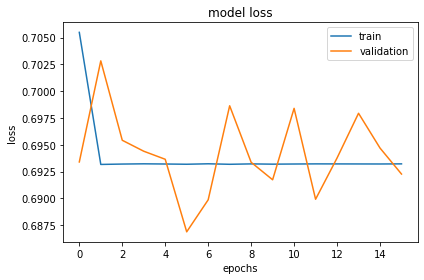

In [ ]:

# Build the model with the optimal hyperparameters and train it on the data
# early stopping to prevent overfitting

es = EarlyStopping(monitor='val_loss',verbose=1, patience= 10)
history = model.fit(train_data_generator, epochs = 50, validation_data = (val_data_generator), class_weight = weights,callbacks =[es])
plt_history(history)

**Evaluation on Validation Set**

In [ ]:
AVG_LIST_PREDICTIONS_VAL = []
MAX_LIST_PREDICTIONS_VAL = []
y_val_labels= []
print("Prediction on validation data using aggregation method")
for path, subdirs, files in os.walk(val_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        if "Epithelioid" in path:
          y_val_labels.append(0.0)
        elif "Nonepithelioid" in path:
          y_val_labels.append(1.0) 

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        #This list contains average score of all 36 test set images
        AVG_LIST_PREDICTIONS_VAL.append(avg(predictions))
        MAX_LIST_PREDICTIONS_VAL.append(max(predictions))

Prediction on validation data using aggregation method


AUC - ROC on validation data average prediction scores: 0.5
-----------------------------------------------------


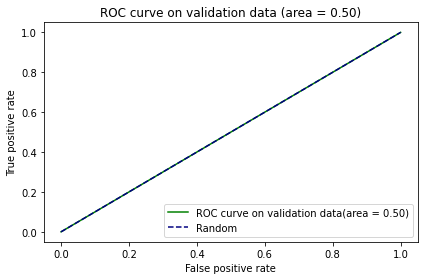

In [ ]:
false_pr_avg,true_pr_avg,threshold = roc_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
roc_auc_avg = auc(false_pr_avg,true_pr_avg)
print("AUC - ROC on validation data average prediction scores:",roc_auc_avg)
print("-----------------------------------------------------")
plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

AUC - ROC on validation data maximum prediction scores: 0.5
-----------------------------------------------------


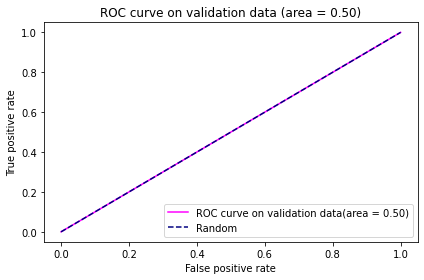

In [ ]:
false_pr_max,true_pr_max,threshold = roc_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
roc_auc_max = auc(false_pr_max,true_pr_max)
print("AUC - ROC on validation data maximum prediction scores:",roc_auc_max)
print("-----------------------------------------------------")
plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

Presicion - Recall auc on validation data average score predictions: 0.6428571428571428
-----------------------------------------------------


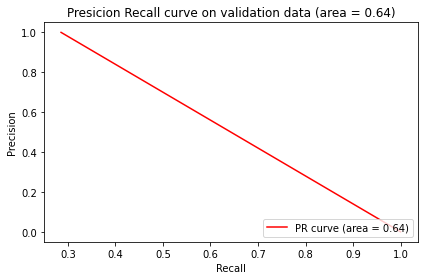

Presicion - Recall auc on validation data maximum score predictions: 0.6428571428571428
-----------------------------------------------------


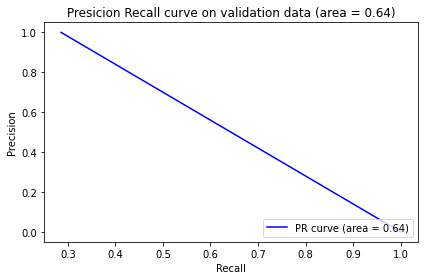

In [ ]:
#presicion - recall curve
precision, recall, threshold = precision_recall_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data average score predictions:",auc(recall,precision))
 
print("-----------------------------------------------------")
plt.plot(precision, recall,color='red',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall,precision)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

precision_max, recall_max, threshold = precision_recall_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data maximum score predictions:",auc(recall_max,precision_max))
print("-----------------------------------------------------")
plt.plot(precision_max, recall_max,color='blue',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [ ]:
import sklearn
#classification report on average prediction values
AVG_LIST_PREDICTIONS_VAL = [round(x) for x in AVG_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS")
print(sklearn.metrics.classification_report(y_val_labels,AVG_LIST_PREDICTIONS_VAL))

print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")

#classification report on maximum prediction values
MAX_LIST_PREDICTIONS_VAL = [round(x) for x in MAX_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS")
print(sklearn.metrics.classification_report(y_val_labels,MAX_LIST_PREDICTIONS_VAL))

CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83        20
         1.0       0.00      0.00      0.00         8

    accuracy                           0.71        28
   macro avg       0.36      0.50      0.42        28
weighted avg       0.51      0.71      0.60        28

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83        20
         1.0       0.00      0.00      0.00         8

    accuracy                           0.71        28
   macro avg       0.36      0.50      0.42        28
weighted avg       0.51      0.71      0.60        28



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Evaluation on Test Set**

In [ ]:
AVG_LIST_PREDICTIONS = []
MAX_LIST_PREDICTIONS = []
y_test_labels= []
print("Prediction on test using aggregation method")
for path, subdirs, files in os.walk(test_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        y_labels(path)

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        AVG_LIST_PREDICTIONS.append(avg(predictions))
        MAX_LIST_PREDICTIONS.append(max(predictions))

Prediction on test using aggregation method


In [ ]:
#AUC - ROC score
false_pr_avg,true_pr_avg,threshold = roc_curve(y_test_labels,AVG_LIST_PREDICTIONS)
roc_auc_avg = auc(false_pr_avg,true_pr_avg)
print("AUC - ROC on Test data average prediction scores:",roc_auc_avg)

AUC - ROC on Test data average prediction scores: 0.5


-----------------------------------------------------


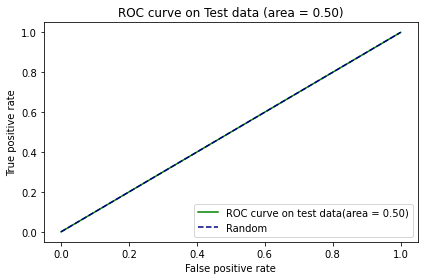

In [ ]:
print("-----------------------------------------------------")
plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [ ]:
false_pr_max,true_pr_max,threshold = roc_curve(y_test_labels,MAX_LIST_PREDICTIONS)
roc_auc_max = auc(false_pr_max,true_pr_max)
print("AUC - ROC on Test data maximum prediction scores:",roc_auc_max)

AUC - ROC on Test data maximum prediction scores: 0.5


-----------------------------------------------------


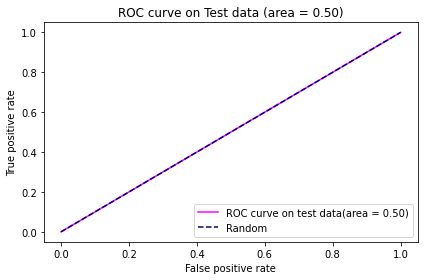

In [ ]:
print("-----------------------------------------------------")
plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

Presicion - Recall auc on test data average score predictions: 0.6
-----------------------------------------------------


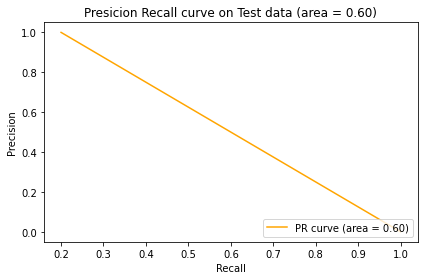

In [ ]:
#presicion - recall curve
precision, recall, threshold = precision_recall_curve(y_test_labels,AVG_LIST_PREDICTIONS)
print("Presicion - Recall auc on test data average score predictions:",auc(recall,precision))
print("-----------------------------------------------------")
plt.plot(precision, recall,color='orange',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall,precision)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

Presicion - Recall auc on test data maximum score predictions: 0.6
-----------------------------------------------------


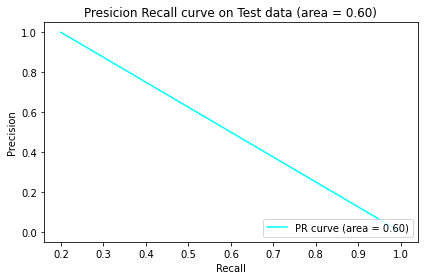

In [ ]:
precision_max, recall_max, threshold = precision_recall_curve(y_test_labels,MAX_LIST_PREDICTIONS)
print("Presicion - Recall auc on test data maximum score predictions:",auc(recall_max,precision_max))
print("-----------------------------------------------------")
plt.plot(precision_max, recall_max,color='cyan',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
AVG_LIST_PREDICTIONS = [round(x) for x in AVG_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT")
print(classification_report(y_test_labels,AVG_LIST_PREDICTIONS))
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
MAX_LIST_PREDICTIONS = [round(x) for x in MAX_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT for MAX VALUE PREDICTIONS")
print(classification_report(y_test_labels,MAX_LIST_PREDICTIONS))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89        20
         1.0       0.00      0.00      0.00         5

    accuracy                           0.80        25
   macro avg       0.40      0.50      0.44        25
weighted avg       0.64      0.80      0.71        25

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
CLASSIFICATION REPORT for MAX VALUE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89        20
         1.0       0.00      0.00      0.00         5

    accuracy                           0.80        25
   macro avg       0.40      0.50      0.44        25
weighted avg       0.64      0.80      0.71        25



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**SAVING THE PREDICTIONS**

In [ ]:
#creating a datframe to save predictions with actuals
df = pd.DataFrame()
df['Average'] = AVG_LIST_PREDICTIONS
df['Maximum'] = MAX_LIST_PREDICTIONS
df['Actual labels'] = y_test_labels
#saving into csv file for futher use
df.to_csv('fold3_2000_kerastuner_test_vgg19.csv',index = False,header = True)
!cp fold3_2000_kerastuner_test_vgg19.csv "drive/My Drive/"

In [ ]:
#creating a datframe to save predictions with actuals
df_val = pd.DataFrame()
df_val['Average'] = AVG_LIST_PREDICTIONS_VAL
df_val['Maximum'] = MAX_LIST_PREDICTIONS_VAL
df_val['Actual labels'] = y_val_labels
#saving into csv file for futher use
df_val.to_csv('fold3_2000_kerastuner_val_vgg19.csv',index = False,header = True)
!cp fold3_2000_kerastuner_val_vgg19.csv "drive/My Drive/"

In [ ]:
#saving the model
model.save("fold3_2000_kerastuner_vgg19.h5")
!cp fold3_2000_kerastuner_vgg19.h5 "drive/My Drive/"